In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon May 29 22:08:31 2023

@author: user
"""
from hyperopt.plotting import main_plot_history, main_plot_vars
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score


import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
import os
import sys
sys.path.append(r'C:\Users\user\OneDrive - University of Haifa\שולחן העבודה\amit\תואר\שנה א\סמסטר ב\ml duDI\hw')
from methods import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris

from hyperopt import hp, tpe, fmin, Trials
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import r2_score
from keras.models import clone_model
def scores(tn,fp,fn,tp):
    accuracy=(tn+tp)/(tn+tp+fp+fn)
    precision=(tp)/(tp+fp)
    recall=(tp)/(tp+fn)
    f1=2*((precision*recall)/(precision+recall))
        
    return round(accuracy,2),round(precision,2),round(recall,2),round(f1,2)


def mean_from_scores(scores):
        sum_var=0
        count_var=0
        for i in scores:
            sum_var+=i
            count_var+=1
        return sum_var/count_var    
#%%

def cross_validation(k,xtrain,ytrain):
    kf = KFold(n_splits=k)    

    x_lst_train = []
    x_lst_val = []
    y_lst_train = []
    y_lst_val = []
            
    for train_index, val_index in kf.split(xtrain):
        x_lst_train.append(xtrain[train_index])
        x_lst_val.append(xtrain[val_index])
        y_lst_train.append(ytrain[train_index])
        y_lst_val.append(ytrain[val_index])

    return x_lst_train, x_lst_val, y_lst_train, y_lst_val



def nested_cross_validation(k_outer,k_inner,xtrain,ytrain):
    x_train_outer_fold,x_val_outer_fold,y_train_outer_fold,y_val_outer_fold = cross_validation(k_outer,xtrain,ytrain)

    x_train_inner_fold = []
    x_val_inner_fold = []
    y_train_inner_fold = []
    y_val_inner_fold = []

    for cv_x_train,cv_y_train in zip(x_train_outer_fold,y_train_outer_fold):
        x_train_inner_fold_var,x_val_inner_fold_var,y_train_inner_fold_var,y_val_inner_fold_var = cross_validation(k_inner,np.array(cv_x_train),np.array(cv_y_train))
            
        x_train_inner_fold.append(x_train_inner_fold_var)
        x_val_inner_fold.append(x_val_inner_fold_var)
        y_train_inner_fold.append(y_train_inner_fold_var)
        y_val_inner_fold.append(y_val_inner_fold_var)
 
    return x_train_outer_fold,x_val_outer_fold,y_train_outer_fold,y_val_outer_fold,x_train_inner_fold,x_val_inner_fold,y_train_inner_fold,y_val_inner_fold


#%%
iris = load_iris()
x_df=pd.DataFrame(iris.data)
x_df=x_df.iloc[50:,:]
x_df.columns=iris.feature_names
cat=pd.DataFrame(iris.target_names).rename(columns={0:'name'})
cat=cat.iloc[:2,:]
y_df=pd.DataFrame(iris.target).rename(columns={0:'cat'})
y_df=y_df.iloc[50:,:]

x=x_df.to_numpy()
y=y_df.to_numpy()
y-=1
#%%
#%%train test split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,shuffle=True,random_state=4) 
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.2,shuffle=True,random_state=4) 


x_train_outer_fold,x_val_outer_fold,y_train_outer_fold,y_val_outer_fold,x_train_inner_fold,x_val_inner_fold,y_train_inner_fold,y_val_inner_fold=nested_cross_validation(5,3,x_train,y_train)
#%%



#%%for each outer itaration: create inner cv and use the same one created on all hyperparameter 

param_grid_knn = {
    'n': hp.choice('neighbors', range(3, 17,2))
}

param_grid_svm = {
    'c': hp.quniform('reg_value',0.025, 10, 0.025),
    'kernel': hp.choice('reg', ['linear', 'poly', 'sigmoid','rbf'])
}
#%%
def create_knn_model(
        n,
):
    model = KNeighborsClassifier(n_neighbors = n)
    
    return model

def create_svm_model(
        c,
        kernel

):

    #build model
    model = svm.SVC(C=c,kernel=kernel)

    return model

def objective_svm(params
):
    global x_train_outer_fold
    global x_val_outer_fold
    global y_train_outer_fold
    global y_val_outer_fold
    global x_train_inner_fold
    global x_val_inner_fold
    global y_train_inner_fold
    global y_val_inner_fold 
    
    global best_loss
    global best_model
    global loss_inner
    global outer_i
    global val_inner
    global params_l
    global best_params
    new_models = []
    for inner_cv in x_train_inner_fold:
        new_models.append(create_svm_model(c=params['c'] ,kernel=params['kernel'])
)
        
    e=[]
    a=[]
    #########         stage 3 ############################ 
    for index, inner_fold in enumerate(x_train_inner_fold[outer_i]):
        model=new_models[index]

        model.fit(np.array(x_train_inner_fold[outer_i][index]), np.array(y_train_inner_fold[outer_i][index]).ravel())
        
        e.append(model.score(np.array(x_train_inner_fold[outer_i][index]),y_train_inner_fold[outer_i][index]))
        y_pred_val=model.predict(np.array(x_val_inner_fold[outer_i][index]))
        
        accuracy = accuracy_score(np.array(y_val_inner_fold[outer_i][index]), y_pred_val)
        a.append(accuracy)
        
    #add early stop?

    loss = -mean_from_scores(e)
    loss_inner.append(loss)

    val_loss=-mean_from_scores(a)
    val_inner.append(val_loss)

    
    params_l.append(params)

    
    if val_loss < best_loss:
        best_model=model
        best_loss = val_loss
        best_params=params
    del model
    return val_loss

def objective_knn(params
):
    global x_train_outer_fold
    global x_val_outer_fold
    global y_train_outer_fold
    global y_val_outer_fold
    global x_train_inner_fold
    global x_val_inner_fold
    global y_train_inner_fold
    global y_val_inner_fold 
    
    global best_loss
    global best_model
    global loss_inner
    global outer_i
    global val_inner
    global params_l
    global best_params
    new_models = []
    for inner_cv in x_train_inner_fold:
        new_models.append(create_knn_model(params['n'])
)
        
    e=[]
    a=[]
    #########         stage 4 ############################ 

    for index, inner_fold in enumerate(x_train_inner_fold[outer_i]):
        model=new_models[index]

        model.fit(np.array(x_train_inner_fold[outer_i][index]), np.array(y_train_inner_fold[outer_i][index]).ravel())
        
        e.append(model.score(np.array(x_train_inner_fold[outer_i][index]),y_train_inner_fold[outer_i][index]))
        y_pred_val=model.predict(np.array(x_val_inner_fold[outer_i][index]))
        
        accuracy = accuracy_score(np.array(y_val_inner_fold[outer_i][index]), y_pred_val)
        a.append(accuracy)
        
    #add early stop?

    loss = -mean_from_scores(e)
    loss_inner.append(loss)

    val_loss=-mean_from_scores(a)
    val_inner.append(val_loss)

    
    params_l.append(params)

    
    if val_loss < best_loss:
        best_model=model
        best_loss = val_loss
        best_params=params
    del model
    return val_loss


#%%
best_loss = float('inf')





def ml_pipeline(models_names,objective_list,param_grid_list):

    #all models
    best_model_g_g=[]
    loss_inner_g_g=[]
    val_inner_g_g=[]
    trials_all_g_g=[]
    search_g_g=[]
    best_params_g_g=[]
    params_g_g=[]
    best_loss_g_g=[]

    global outer_i
    #########         stage 2 ############################ 
    #per hyper model
    for hypmodel_i,hypmodel in enumerate(models_names):
        global best_loss

        outer_i=0

        best_model_g=[]
        loss_inner_g=[]
        val_inner_g=[]
        trials_all_g=[]
        search_g=[]
        best_params_g=[]
        params_g=[]
        best_loss_g=[]
        #########         stage 3 ############################ 

        for i,outer_fold in enumerate(x_train_outer_fold):
            global val_inner
            global params_l
            global best_loss
            global loss_inner
            global best_params
            global best_model
            best_model=None

            loss_inner=[]
            val_inner=[]
            params_l=[]
            best_params=0
            trials_g = Trials()
            #########         stage 5 ############################ 

            search = fmin(
                fn=objective_list[hypmodel_i],
                space=param_grid_list[hypmodel_i],
                max_evals=100,
                algo=tpe.suggest,  # tpe #rand.suggest
                trials=trials_g
            )
            print(best_params)
            best_model_g.append(best_model)
            loss_inner_g.append(loss_inner)
            val_inner_g.append(val_inner)
            
        
            trials_all_g.append(trials_g)
            search_g.append(search)
            best_params_g.append(best_params)
            params_g.append(params_l)
            outer_i+=1
            best_loss_g.append(best_loss)
            best_loss += float('inf')
        best_model_g_g.append(best_model_g)
        loss_inner_g_g.append(loss_inner_g)
        val_inner_g_g.append(val_inner_g)
        trials_all_g_g.append(trials_all_g)
        search_g_g.append(search_g)
        best_params_g_g.append(best_params_g)
        params_g_g.append(params_g)
        best_loss_g_g.append(best_loss_g)
    return best_model_g_g, loss_inner_g_g, val_inner_g_g,trials_all_g_g,search_g_g,best_params_g_g,params_g_g,best_loss_g_g





In [3]:
best_model_g_g, loss_inner_g_g, val_inner_g_g,trials_all_g_g,search_g_g,best_params_g_g,params_g_g,best_loss_g_g=ml_pipeline(['knn','svm'],[objective_knn,objective_svm],[param_grid_knn,param_grid_svm])


100%|█████████████████████████████████████████████| 100/100 [00:01<00:00, 77.17trial/s, best loss: -0.9411764705882352]
{'n': 7}
100%|█████████████████████████████████████████████| 100/100 [00:01<00:00, 77.98trial/s, best loss: -0.9215686274509803]
{'n': 7}
100%|█████████████████████████████████████████████| 100/100 [00:01<00:00, 74.59trial/s, best loss: -0.8627450980392156]
{'n': 3}
100%|█████████████████████████████████████████████| 100/100 [00:01<00:00, 78.32trial/s, best loss: -0.9019607843137255]
{'n': 7}
100%|█████████████████████████████████████████████| 100/100 [00:01<00:00, 75.61trial/s, best loss: -0.8867102396514163]
{'n': 13}
100%|████████████████████████████████████████████| 100/100 [00:00<00:00, 134.22trial/s, best loss: -0.9803921568627452]
{'c': 2.475, 'kernel': 'rbf'}
100%|████████████████████████████████████████████| 100/100 [00:00<00:00, 136.33trial/s, best loss: -0.9607843137254902]
{'c': 1.6, 'kernel': 'linear'}
100%|████████████████████████████████████████████| 10

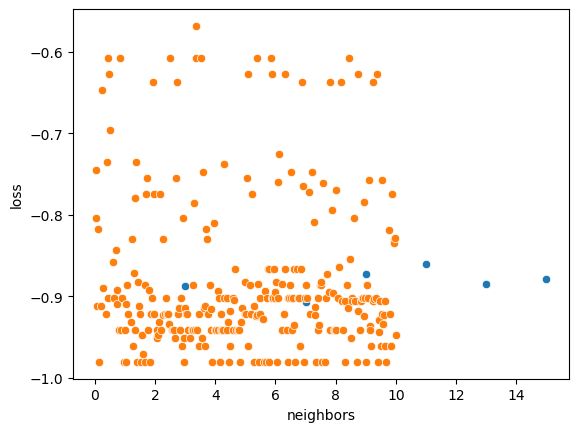

In [4]:



#%%
        #########         stage 6 ############################ 

#%%knn hyperspace
params_knn = [j.get('n') for i in params_g_g[0] for j in i]
loss_knn=[j for i in val_inner_g_g[0] for j in i]

knn_val_loss_df=pd.DataFrame([params_knn,loss_knn]).T.rename(columns={0:'neighbors',1:'loss'})
knn_val_loss_df_grouped=knn_val_loss_df.groupby(by='neighbors')['loss'].mean()


sns.scatterplot(knn_val_loss_df_grouped)
#%%svm hyperspace
params_svm_c = [j.get('c') for i in params_g_g[1] for j in i]
params_svm_kernel= [j.get('kernel') for i in params_g_g[1] for j in i]
loss_svm=[j for i in val_inner_g_g[1] for j in i]

svm_val_loss_df_c=pd.DataFrame([params_svm_c,loss_svm]).T.rename(columns={0:'c',1:'loss'})
svm_val_loss_df_grouped_c=svm_val_loss_df_c.groupby(by='c')['loss'].mean()


sns.scatterplot(svm_val_loss_df_grouped_c)
plt.show()


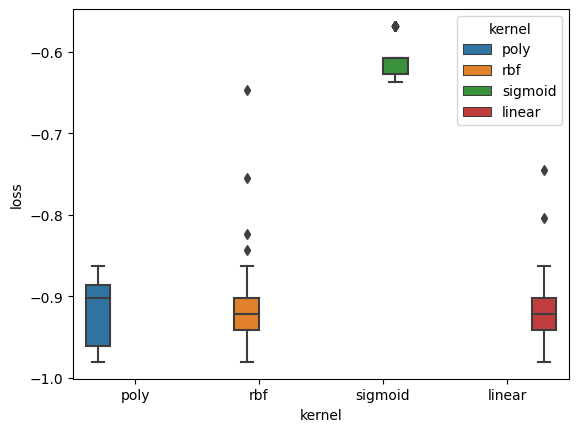

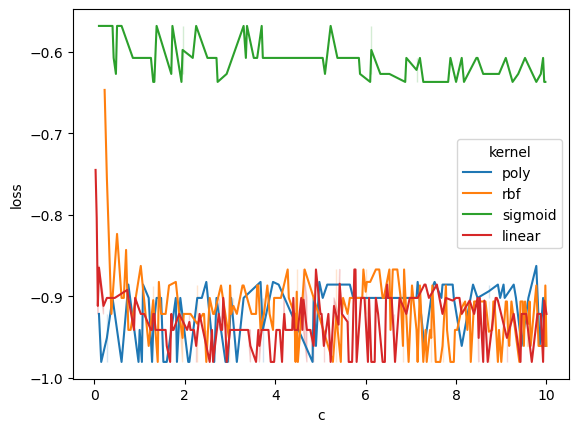

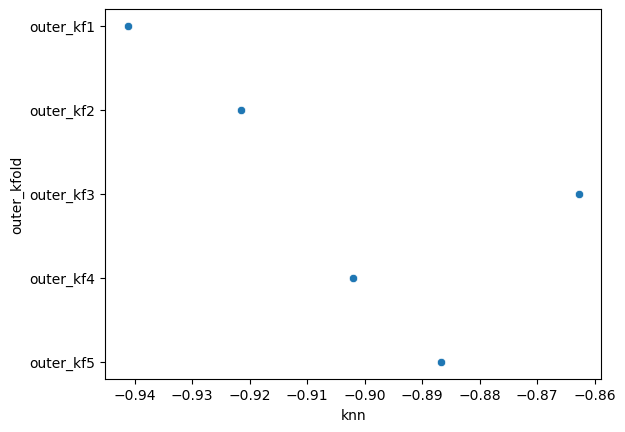

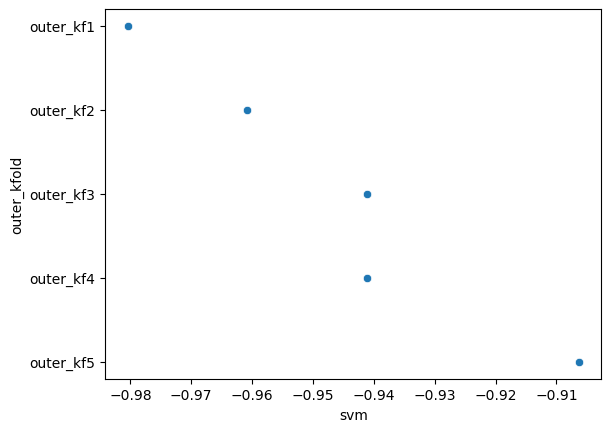

In [6]:

svm_val_loss_df_kernel=pd.DataFrame([params_svm_kernel,loss_svm]).T.rename(columns={0:'kernel',1:'loss'})


sns.boxplot(svm_val_loss_df_kernel,y='loss',hue='kernel',x='kernel')
plt.show()

com_svm_df=pd.concat([svm_val_loss_df_c[['c']],svm_val_loss_df_kernel],axis=1)

sns.lineplot(com_svm_df,x='c',y='loss',hue='kernel')

plt.show()
#%%outercv within validation

#knn
df=pd.DataFrame(best_loss_g_g).T.rename(columns={0:'knn',1:'svm'})
df['outer_kfold']=['outer_kf1','outer_kf2','outer_kf3','outer_kf4','outer_kf5']
sns.scatterplot(df,x='knn',y='outer_kfold')
plt.show()
sns.scatterplot(df,x='svm',y='outer_kfold')
plt.show()


#%%



#%%getting per kfold hyperparameters :
        #########         stage 6  ############################ 

model_hyper_params=[]
for i,model in enumerate(best_loss_g_g):
    model_hyper_params.append((best_params_g_g[i]))

       

    
#########         stage 7  ############################ 

models_retrain_knn=[]
models_retrain_knn_accuracy=[]

for outer_kfold,hyper_params in enumerate(model_hyper_params[0]):
    n=hyper_params.get('n')
    model_var=create_knn_model(n)
    model_var.fit(np.array(x_train_outer_fold[outer_kfold]), np.array(y_train_outer_fold[outer_kfold]).ravel())
    y_pred_val=model_var.predict(np.array(x_val_outer_fold[outer_kfold]))
    accuracy = accuracy_score(np.array(y_val_outer_fold[outer_kfold]), y_pred_val)
    models_retrain_knn.append(model_var)
    models_retrain_knn_accuracy.append(accuracy)



models_retrain_svm=[]
models_retrain_svm_accuracy=[]

for outer_kfold,hyper_params in enumerate(model_hyper_params[1]):
    c=hyper_params.get('c')
    kernel=hyper_params.get('kernel')

    model_var=create_svm_model(c=c,kernel=kernel)
    model_var.fit(np.array(x_train_outer_fold[outer_kfold]), np.array(y_train_outer_fold[outer_kfold]).ravel())
    y_pred_val=model_var.predict(np.array(x_val_outer_fold[outer_kfold]))
    accuracy = accuracy_score(np.array(y_val_outer_fold[outer_kfold]), y_pred_val)
    models_retrain_svm.append(model_var)
    models_retrain_svm_accuracy.append(accuracy)


#%%


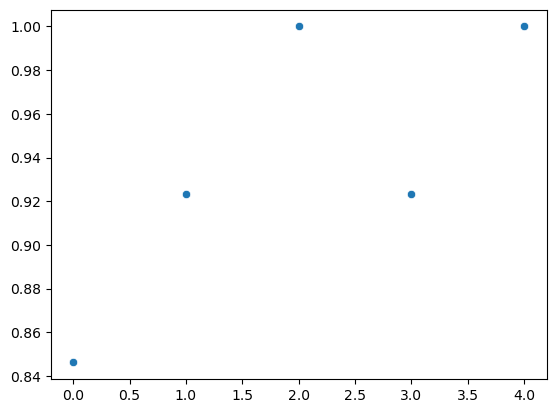

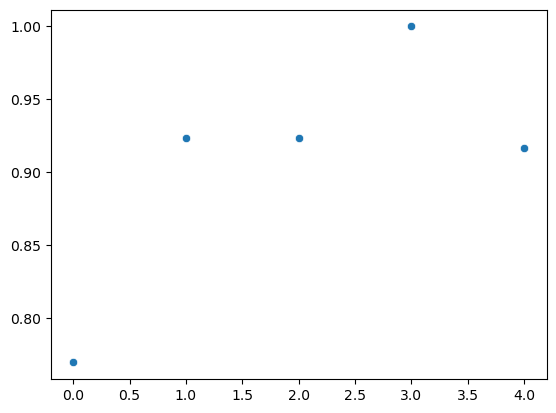

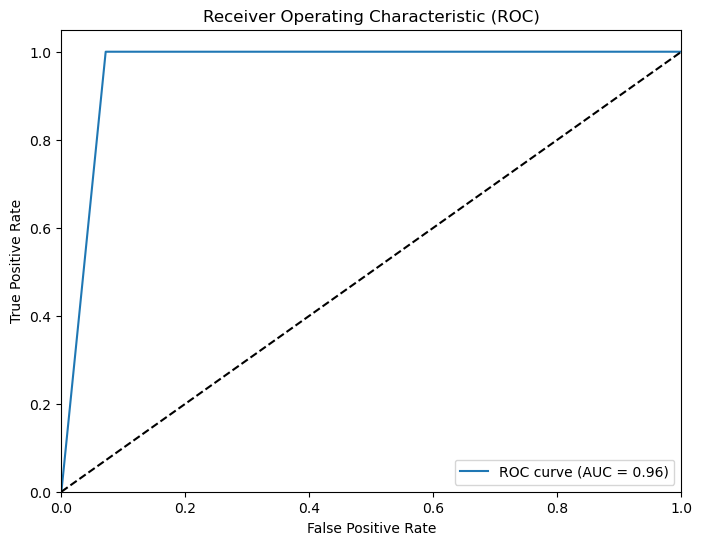

Confusion Matrix:
[[13  1]
 [ 0  6]]


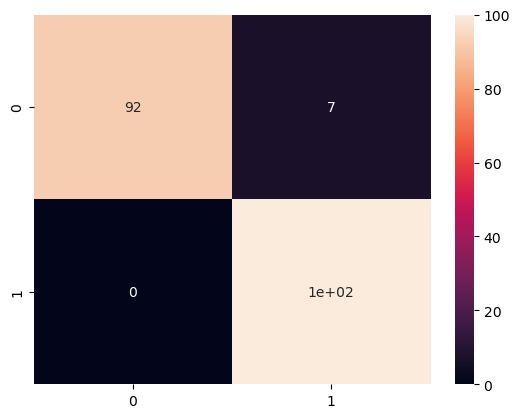

 accuracy 0.96
 precision 0.93 
 recall 1.0 
 f1 0.96 


In [7]:

        #########         stage 8 ############################ 


best_knn_model=models_retrain_knn[models_retrain_knn_accuracy.index(min(models_retrain_knn_accuracy))]
best_svm_model=models_retrain_svm[models_retrain_svm_accuracy.index(min(models_retrain_svm_accuracy))]

        #########         stage 9 ############################ 

knn_val_y_pred_val=best_knn_model.predict(np.array(x_val))
accuracy_knn_val = accuracy_score(np.array(y_val), knn_val_y_pred_val)


svm_val_y_pred_val=best_svm_model.predict(np.array(x_val))
accuracy_svm_val = accuracy_score(np.array(y_val), svm_val_y_pred_val)


#%%
sns.scatterplot(models_retrain_svm_accuracy)
plt.show()

sns.scatterplot(models_retrain_knn_accuracy)
plt.show()

#%%
        #########         stage 10 ############################ 

final_model=create_svm_model(c=9.05,kernel='rbf')
final_model.fit(np.array(x_train), np.array(y_train).ravel())
y_pred_val=final_model.predict(x_test)
accuracy = accuracy_score(np.array(y_test), y_pred_val)
#%%

    #%%

fpr, tpr, thresholds = roc_curve(y_test, y_pred_val)

# Compute the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_val)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing the random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()
#%%
cm = confusion_matrix(y_test, y_pred_val)
print("Confusion Matrix:")
print(cm)
cm[0]=cm[0]/cm[0].sum()*100
cm[1]=cm[1]/cm[1].sum()*100

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
sns.heatmap(cm,annot=True)

plt.show()


#%%

# -*- coding: utf-8 -*-
"""
Created on Wed May 31 17:06:20 2023

@author: user
"""



tn=92
fp=8
fn=0
tp=100
accuracy,precision,recall,f1=scores(tn,fp,fn,tp)


print(f" accuracy {accuracy}\n precision {precision} \n recall {recall} \n f1 {f1} ")

